In [1]:

import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline
import pandas.util.testing as tm


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


# **Data Prepreprocessing**

In [2]:
labels = ['chest', 'hand','skull']

img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
data = get_training_data('/content/drive/MyDrive/Data/data')


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()


skull


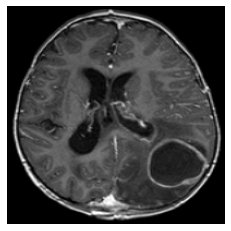

In [7]:
plt.imshow(data[500][0],cmap = 'gray')
plt.axis('off')
print(labels[data[500][1]])

In [9]:
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)



# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [10]:
X_train = X_train / 255
X_test = X_test / 255

In [11]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

# Train Using *CNN* 

In [12]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(200,200,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=epochs)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 99, 99, 8)         80        
_________________________________________________________________
flatten (Flatten)            (None, 78408)             0         
_________________________________________________________________
Softmax (Dense)              (None, 10)                784090    
Total params: 784,170
Trainable params: 784,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
15/15 [==============================] - 1s 64ms/step - loss: 0.9769 - accuracy: 0.6112
Epoch 2/5
15/15 [==============================] - 1s 62ms/step - loss: 0.1803 - accuracy: 0.9310
Epoch 3/5
15/15 [==============================] - 1s 64ms/step - loss: 0.0821 - accuracy: 0.9750
Epoch 4/5
15/15 [==============================] - 1s 63ms/step - loss: 0.0218 - accur

In [14]:
print(model.predict(X_test))

[[2.2464128e-05 1.5724760e-02 9.8425287e-01 ... 2.3495647e-14
  3.0167858e-14 2.7177354e-14]
 [3.3279466e-05 9.9403423e-01 5.9316824e-03 ... 9.9106799e-08
  1.1931303e-07 1.1130280e-07]
 [1.7185440e-07 3.1089314e-04 9.9968898e-01 ... 1.1798344e-20
  1.5496802e-20 1.1803026e-20]
 ...
 [1.9392080e-06 1.3944527e-04 9.9985862e-01 ... 7.7800981e-11
  8.8267400e-11 7.2250372e-11]
 [9.2986238e-06 5.8627436e-03 9.9412799e-01 ... 2.7950522e-17
  3.3593320e-17 3.4089159e-17]
 [2.1503731e-05 1.0700729e-03 9.9890840e-01 ... 7.5858672e-13
  8.0555300e-13 7.4447919e-13]]


# **Saving the Model**

In [19]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}


export_path = /tmp/1

INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 88
drwxr-xr-x 2 root root  4096 Feb 14 05:16 assets
-rw-r--r-- 1 root root 79078 Feb 14 05:18 saved_model.pb
drwxr-xr-x 2 root root  4096 Feb 14 05:18 variables


In [20]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major is 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [21]:
import subprocess

In [29]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Conv1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 200, 200, 1)
        name: serving_default_Conv1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['Softmax'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
W0214 05:24:03.554003 140652923697024 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/pyt

In [23]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  12365      0 --:--:-- --:--:-- --:--:-- 12313
OK
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,012 B]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 http://archi

In [30]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 25 not upgraded.
Need to get 223 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.4.1 [223 MB]
Fetched 223 MB in 3s (68.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 146425 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.4.1_all.deb ...
Unpacking tensorflow-model-server (2.4.1) ...
Setting up tensorflow-model-server (2.4.1) ...


In [31]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [46]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [47]:
!tail server.log

2021-02-14 05:35:02.874187: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:206] Restoring SavedModel bundle.
2021-02-14 05:35:02.875019: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2021-02-14 05:35:02.911148: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:190] Running initialization op on SavedModel bundle at path: /tmp/1
2021-02-14 05:35:02.916069: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 66113 microseconds.
2021-02-14 05:35:02.916742: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /tmp/1/assets.extra/tf_serving_warmup_requests
2021-02-14 05:35:02.916873: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: fashion_model version: 1}
2021-02-14 05:35:02.918327: I tensorflow_serving/model_servers/server.cc:371] 

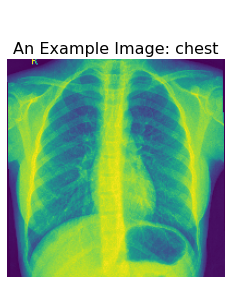

In [48]:
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(200,200))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(X_test)-1)
show(rando, 'An Example Image: {}'.format(labels[y_test[rando]]))

In [49]:
import json
data1 = json.dumps({"signature_name": "serving_default", "instances": X_test[0:3].tolist()})
print('Data: {} ... {}'.format(data1[:50], data1[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ... .6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6745098039215687], [0.6784313725490196], [0.6784313725490196], [0.6745098039215687], [0.6745098039215687], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.6784313725490196], [0.67843137254901

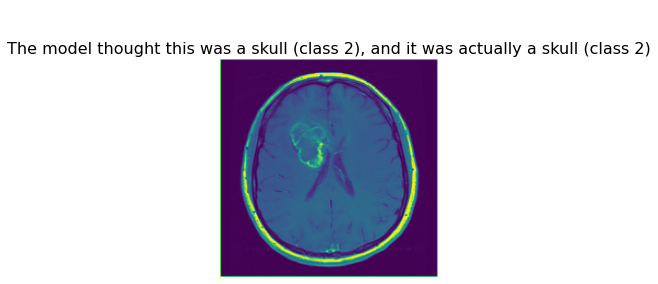

In [52]:
!pip install -q requests

import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model:predict', data=data1, headers=headers)
predictions = json.loads(json_response.text)['predictions']

show(0, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
  labels[np.argmax(predictions[0])], np.argmax(predictions[0]), labels[y_test[0]], y_test[0]))

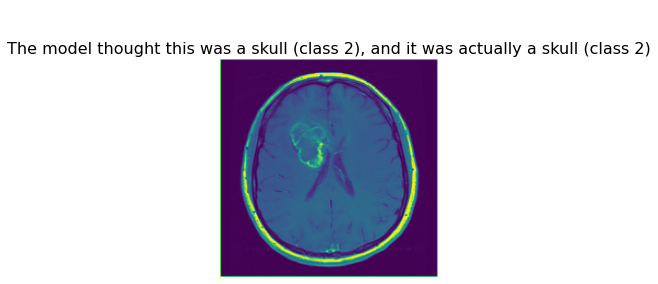

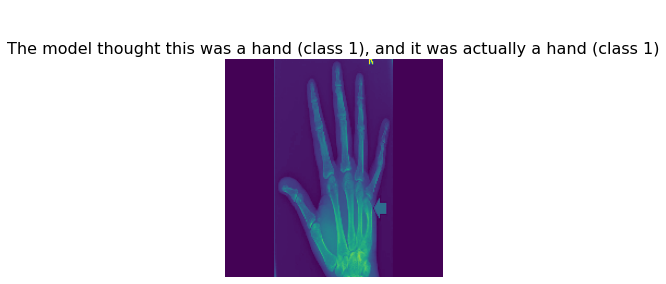

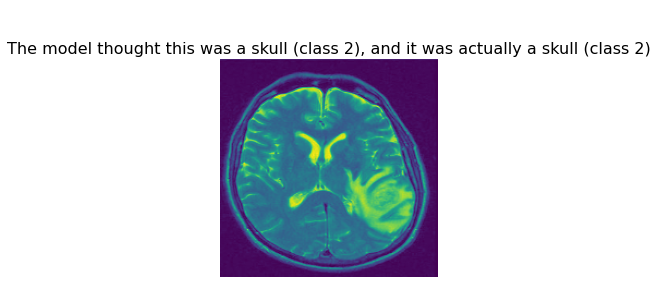

In [54]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion_model/versions/1:predict', data=data1, headers=headers)
predictions = json.loads(json_response.text)['predictions']

for i in range(0,3):
  show(i, 'The model thought this was a {} (class {}), and it was actually a {} (class {})'.format(
    labels[np.argmax(predictions[i])], np.argmax(predictions[i]), labels[y_test[i]], y_test[i]))